In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
import pandas as pd
import os 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [2]:

os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /usr/share/java/mariadb-java-client-2.5.3.jar pyspark-shell'

In [3]:
#Configuración de la sesión
spark_context = SparkContext()
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

In [4]:
PATH = "./data/"

In [5]:
# Importando los datos para trabajar con ellos, esto debido a la imposibilidad de conectarme a sql Server
vuelos_e2 = spark.read.load(PATH+"vuelosEtapa2.csv",format="csv", sep=",", inferSchema="true", header="true")
acinfra = spark.read.load(PATH+"aeropuertos_cambios_infraestructura.csv",format="csv", sep=",", inferSchema="true", header="true")
matriz_dis = spark.read.load(PATH+"Matriz de distancias entre aeropuertos y centros poblados de Colombia1.csv",format="csv", sep=",", inferSchema="true", header="true")
cobertura_aerea = spark.read.load(PATH+"Cobertura Aerea de Centros poblados por categoria de AereopuertoConCodigoCentroPoblado.csv",format="csv", sep=",", inferSchema="true", header="true")

In [6]:
# Se convierte en tipo float para hacer operaciones ya que no funciona con tipo decimal
cobertura_aerea = cobertura_aerea.withColumn("Distancia(Km)",cobertura_aerea["Distancia(Km)"].cast(FloatType()))
cobertura_aerea = cobertura_aerea.withColumn("D_Aerodromo",cobertura_aerea["D_Aerodromo"].cast(FloatType()))
cobertura_aerea = cobertura_aerea.withColumn("D_Regional",cobertura_aerea["D_Regional"].cast(FloatType()))
cobertura_aerea = cobertura_aerea.withColumn("D_Internacional",cobertura_aerea["D_Internacional"].cast(FloatType()))

In [7]:
# Se convierte en tipo float para hacer operaciones ya que no funciona con tipo decimal
vuelos_e2 = vuelos_e2.withColumn("sillas",vuelos_e2["sillas"].cast(FloatType()))
vuelos_e2 = vuelos_e2.withColumn("carga_ofrecida",vuelos_e2["carga_ofrecida"].cast(FloatType()))
vuelos_e2 = vuelos_e2.withColumn("pasajeros",vuelos_e2["pasajeros"].cast(FloatType()))
vuelos_e2 = vuelos_e2.withColumn("carga_bordo",vuelos_e2["carga_bordo"].cast(FloatType()))

In [8]:
# Se convierte en tipo float para hacer operaciones ya que no funciona con tipo decimal
acinfra = acinfra.withColumn("longitud_pista",acinfra["longitud_pista"].cast(FloatType()))
acinfra = acinfra.withColumn("ancho_pista",acinfra["ancho_pista"].cast(FloatType()))
acinfra = acinfra.withColumn("longitud_pista",acinfra["longitud_pista"].cast(FloatType()))
acinfra = acinfra.withColumn("elevacion",acinfra["elevacion"].cast(FloatType()))
acinfra = acinfra.withColumn("numero_vuelos_origen",acinfra["numero_vuelos_origen"].cast(FloatType()))

In [9]:
cobertura_aerea.select('Distancia(Km)', 'D_Aerodromo', 'D_Regional', 'D_Internacional').summary().show()

+-------+------------------+------------------+-----------------+------------------+
|summary|     Distancia(Km)|       D_Aerodromo|       D_Regional|   D_Internacional|
+-------+------------------+------------------+-----------------+------------------+
|  count|              7879|              7879|             7879|              7879|
|   mean|2304.8468978274245| 2314.807427213081|2365.080928418524|2393.3208420553055|
| stddev| 47744.39138609431|47743.925423853965|47741.53626693145| 47740.22357323566|
|    min|       0.022363015|       0.022363015|      0.023008129|        0.03499221|
|    25%|          9.858557|         12.264982|        49.568638|         48.311535|
|    50%|         18.018097|          23.22768|         77.13139|          96.89004|
|    75%|          28.14128|         39.478962|        100.98504|         153.09279|
|    max|          999999.0|          999999.0|         999999.0|          999999.0|
+-------+------------------+------------------+-----------------+

In [10]:
vuelos_e2.select('vuelos', 'sillas', 'carga_ofrecida', 'pasajeros','carga_bordo').summary().show()

+-------+------------------+-----------------+------------------+------------------+------------------+
|summary|            vuelos|           sillas|    carga_ofrecida|         pasajeros|       carga_bordo|
+-------+------------------+-----------------+------------------+------------------+------------------+
|  count|             82559|            82559|             82559|             82559|             82558|
|   mean|14.394953911747962|1298.999927324701| 59751.02508509066|1043.8061870904444|6528.3458417112815|
| stddev|38.071583119682145|5021.319646552459|269353.90228866035| 4057.579610115156| 27560.51657063183|
|    min|                 0|              0.0|               0.0|               0.0|               0.0|
|    25%|                 1|              0.0|               0.0|               2.0|               0.0|
|    50%|                 2|              0.0|               0.0|               8.0|              90.0|
|    75%|                 9|            248.0|           10000.0

In [11]:
acinfra.select('longitud_pista', 'ancho_pista', 'longitud_pista', 'elevacion', 'numero_vuelos_origen').summary().show()

+-------+------------------+------------------+------------------+------------------+--------------------+
|summary|    longitud_pista|       ancho_pista|    longitud_pista|         elevacion|numero_vuelos_origen|
+-------+------------------+------------------+------------------+------------------+--------------------+
|  count|               863|               863|               863|               863|                 863|
|   mean|1209.7891077636152|22.850521436848204|1209.7891077636152| 989.0509849362688|   15449.79258400927|
| stddev|1550.0621945525252|26.082808458054803|1550.0621945525252|1460.8062833235342|  199820.26072160207|
|    min|               0.0|               0.0|               0.0|               0.0|                 0.0|
|    25%|             179.0|               3.0|             179.0|             367.0|                 0.0|
|    50%|             671.0|              15.0|             671.0|             568.0|                 2.0|
|    75%|            1598.0|         

In [12]:
# Funcion para visualizar por medio de histogramas la informacion de los archivos

def histo(df, lista):
    
    for i in df:
        for j in lista:
            if j==i:
                hists = df.select(j).rdd.flatMap(lambda x: x).histogram(10)
        return hists

In [13]:
#Filas de columnas para visualizar
l_cobertura_aerea=['Distancia(Km)', 'D_Aerodromo', 'D_Regional', 'D_Internacional']
l_vuelos_e2=['vuelos', 'sillas', 'carga_ofrecida', 'pasajeros','carga_bordo']
l_acinfra=['longitud_pista', 'ancho_pista', 'longitud_pista', 'elevacion', 'numero_vuelos_origen']

In [14]:
import numpy as np
import matplotlib.pyplot as mplt
import matplotlib.ticker as mtick


def plotHistogramData(df, columna):
    data = df.select(columna).rdd.flatMap(lambda x: x).histogram(10)
    binSides, binCounts = data
    binSides = [round(i, 2) for i in binSides]
    N = len(binCounts)
    ind = np.arange(N)
    width = 1

    fig, ax = mplt.subplots()
    rects1 = ax.bar(ind+0.5, binCounts, width, color='b')
    
    fig.set_size_inches(1.3*N, 8)

    ax.set_ylabel('Frecuencia')
    ax.set_xlabel('Rango')
    ax.set_title(columna)
    ax.set_xticks(np.arange(N+1))
    ax.set_xticklabels(binSides)

    mplt.show()



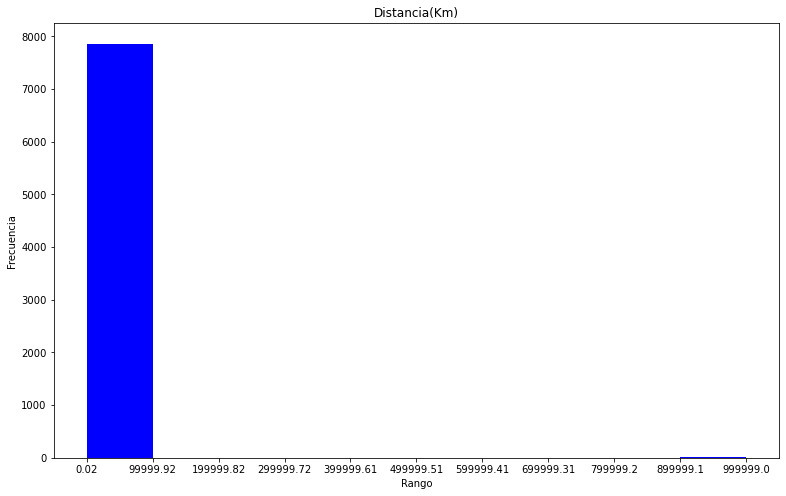

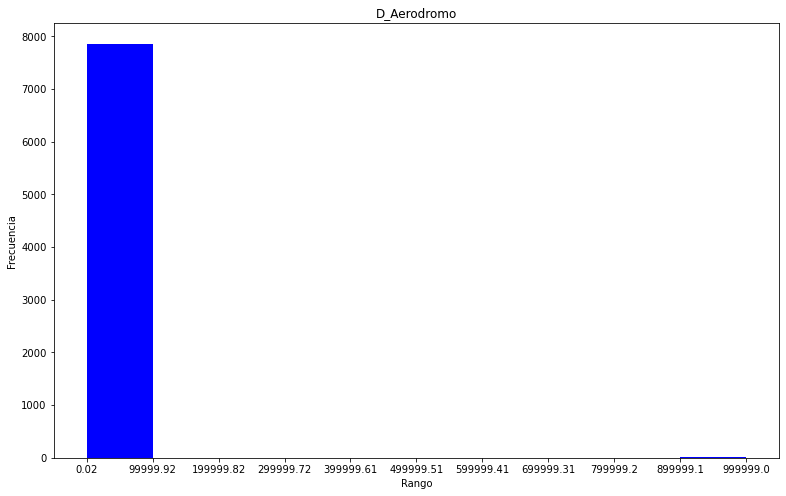

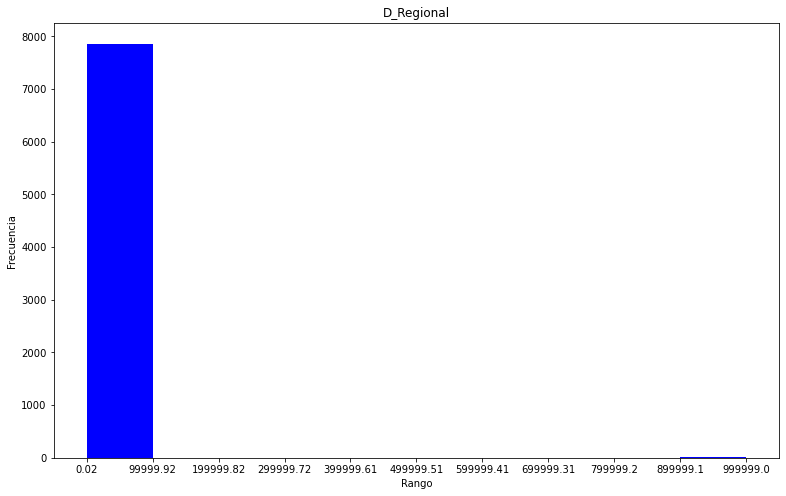

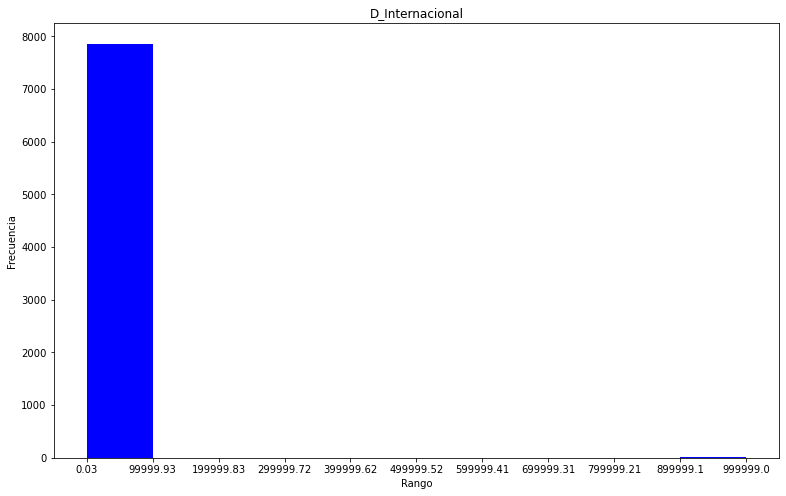

In [15]:
for i in l_cobertura_aerea:
    plotHistogramData(cobertura_aerea, i)
    

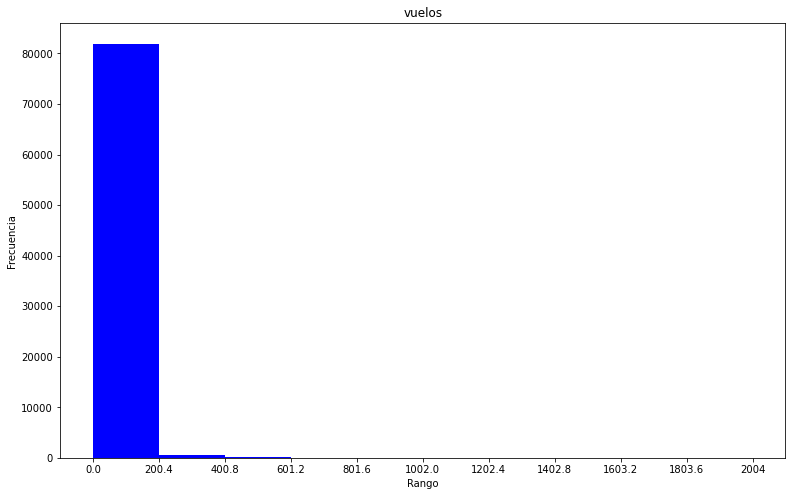

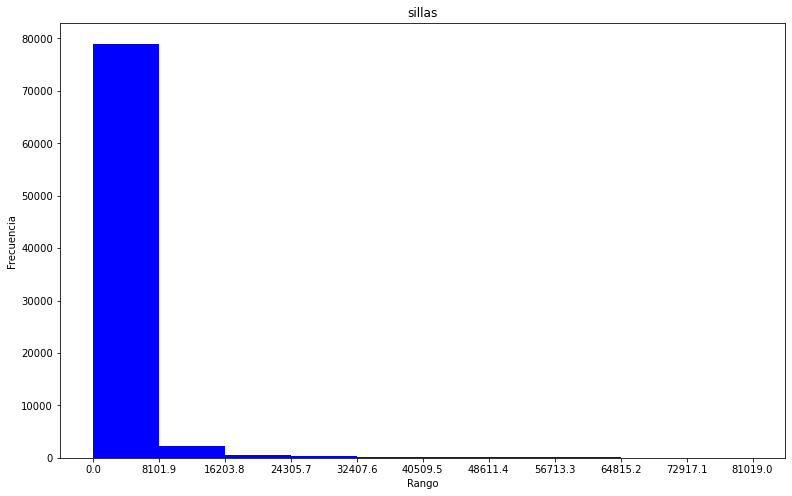

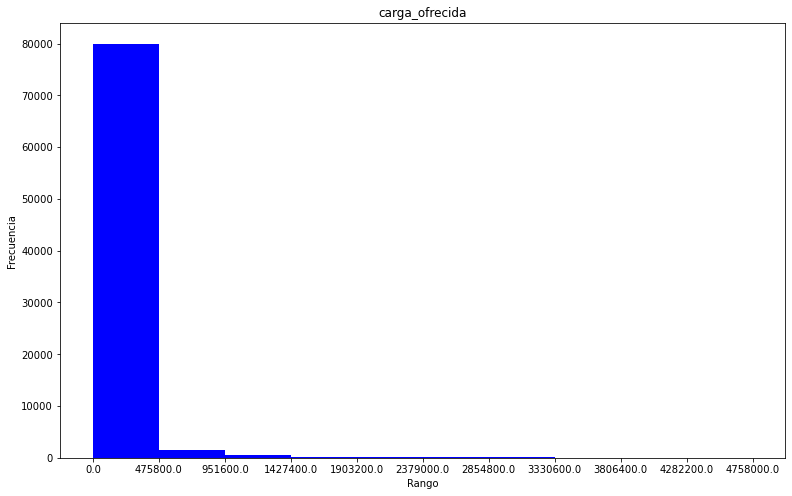

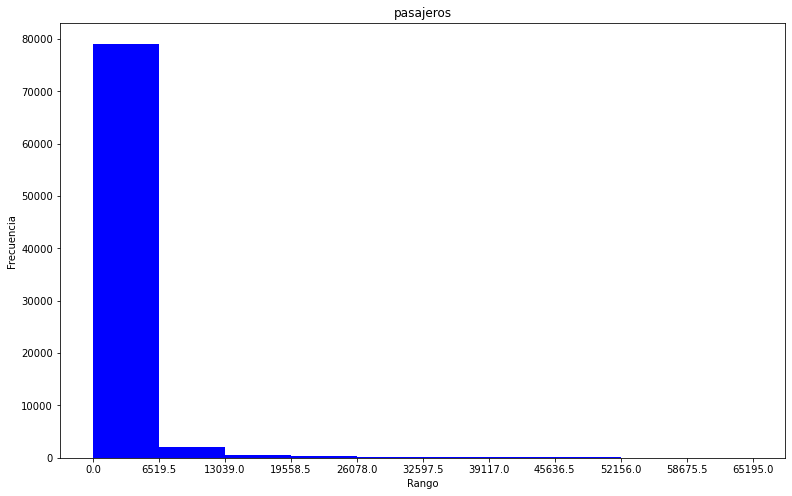

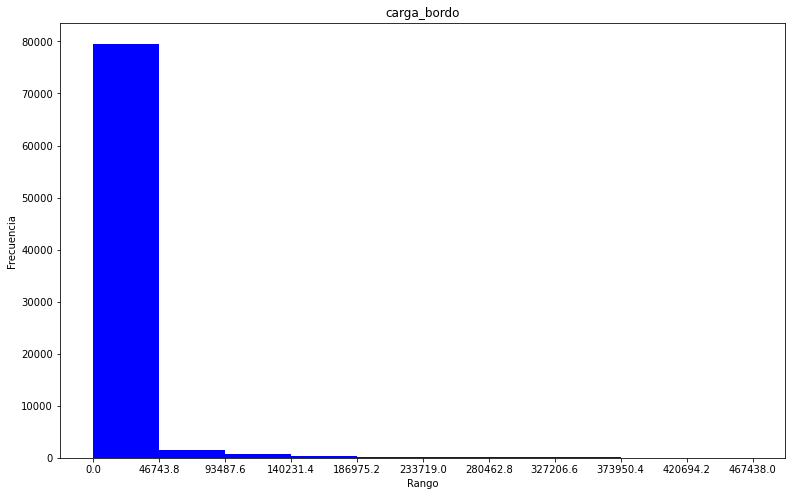

In [16]:
for i in l_vuelos_e2:
    plotHistogramData(vuelos_e2, i)
    

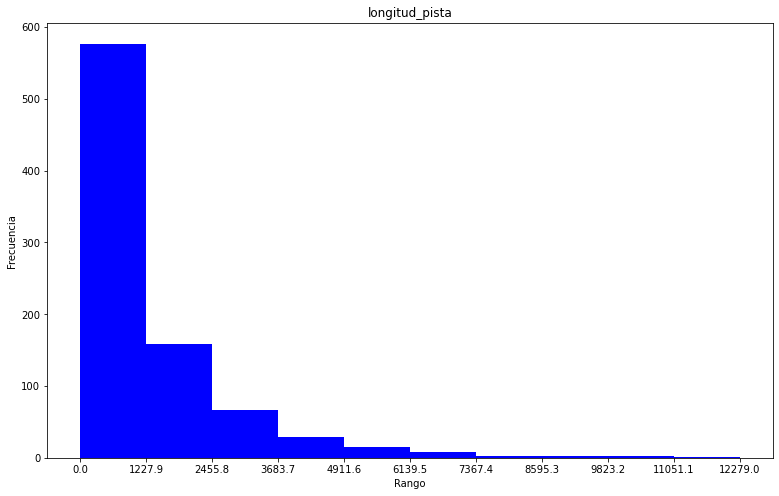

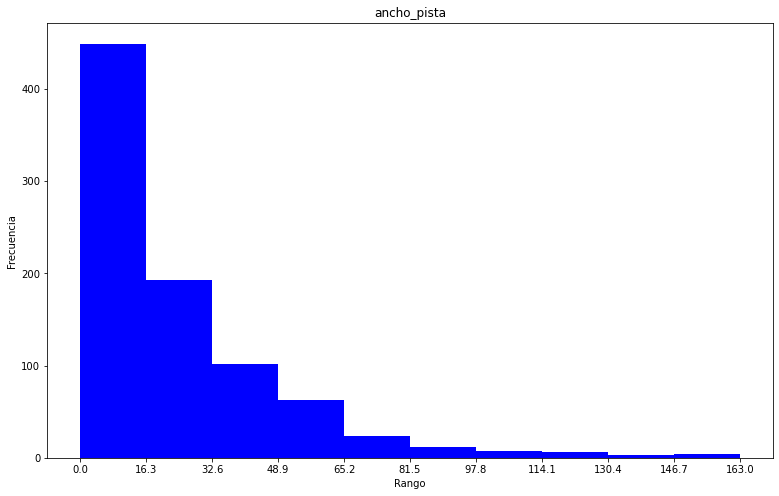

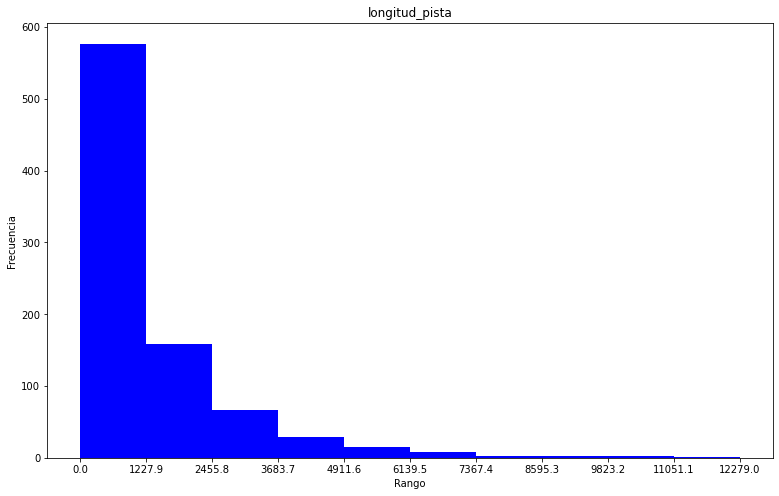

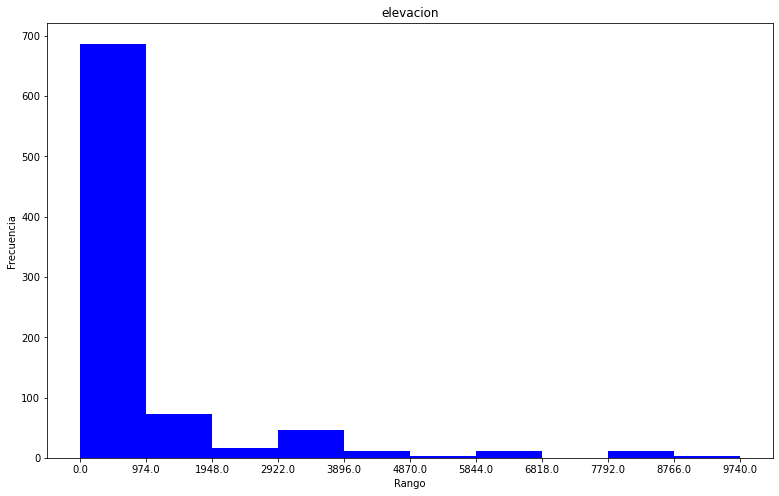

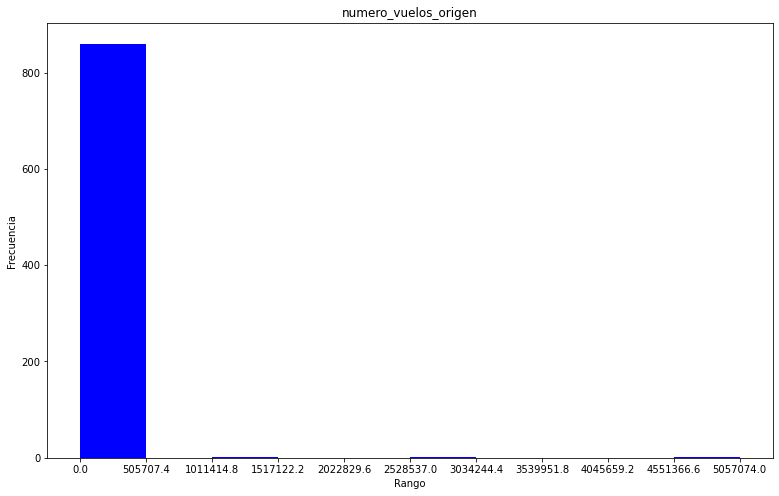

In [17]:
for i in l_acinfra:
    plotHistogramData(acinfra, i)

In [18]:
#Estadisticas de la tablas de vuelos, tipo de vuelo
vuelos_e2.groupBy('tipo_vuelo').agg({'vuelos':'max','sillas': 'mean',  'carga_bordo': 'mean','carga_ofrecida': 'count', 'pasajeros': 'max'}).show()

+----------+--------------+---------------------+-----------+------------------+------------------+
|tipo_vuelo|max(pasajeros)|count(carga_ofrecida)|max(vuelos)|  avg(carga_bordo)|       avg(sillas)|
+----------+--------------+---------------------+-----------+------------------+------------------+
|         T|        3020.0|                50399|       2004|420.61921107980476|               0.0|
|         C|        8429.0|                  782|         59|13736.482097186701|1776.6892583120205|
|         A|        3205.0|                 1430|         35| 466.9762237762238|289.74825174825173|
|         R|       65195.0|                29948|        542|16907.943902764793|3520.7834913850675|
+----------+--------------+---------------------+-----------+------------------+------------------+



In [19]:
#Estadisticas de la tablas de vuelos, trafico
vuelos_e2.groupBy('trafico').agg({'vuelos':'max','sillas': 'mean',  'carga_bordo': 'mean','carga_ofrecida': 'count', 'pasajeros': 'max'}).show()

+-------+--------------+---------------------+-----------+------------------+-----------------+
|trafico|max(pasajeros)|count(carga_ofrecida)|max(vuelos)|  avg(carga_bordo)|      avg(sillas)|
+-------+--------------+---------------------+-----------+------------------+-----------------+
|      N|       65195.0|                82559|       2004|6528.3458417112815|1298.999927324701|
+-------+--------------+---------------------+-----------+------------------+-----------------+



In [20]:
#Estadisticas de la tablas de vuelos, año
vuelos_e2.groupBy('ano').agg({'vuelos':'max','sillas': 'mean',  'carga_bordo': 'mean','carga_ofrecida': 'count', 'pasajeros': 'max'}).show()

+----+--------------+---------------------+-----------+------------------+------------------+
| ano|max(pasajeros)|count(carga_ofrecida)|max(vuelos)|  avg(carga_bordo)|       avg(sillas)|
+----+--------------+---------------------+-----------+------------------+------------------+
|2015|       60751.0|                10881|        542|       9166.203125|1697.8820880433784|
|2013|       65195.0|                13413|        533| 5169.295310519645|1099.3143219264891|
|2014|       63813.0|                13276|        540| 6582.980114492317|1244.4859897559506|
|2012|       58917.0|                12426|        452| 4733.363351038146|1096.7912441654596|
|2016|       56408.0|                10691|        458| 9436.738658684875|1752.0681881956787|
|2010|       38680.0|                10461|       2004| 5714.983844756715|1199.0277220151038|
|2011|       50628.0|                11411|        401|5522.5740075365875|1104.1506441153274|
+----+--------------+---------------------+-----------+-----

In [21]:
#Estadisticas de la tablas de vuelos, destino
vuelos_e2.groupBy('destino').agg({'vuelos':'max','sillas': 'mean',  'carga_bordo': 'mean','carga_ofrecida': 'count', 'pasajeros': 'max'}).show()

+-------+--------------+---------------------+-----------+------------------+------------------+
|destino|max(pasajeros)|count(carga_ofrecida)|max(vuelos)|  avg(carga_bordo)|       avg(sillas)|
+-------+--------------+---------------------+-----------+------------------+------------------+
|    9CL|           2.0|                    2|          1|             100.0|               0.0|
|    7HC|           5.0|                    1|          1|              40.0|               0.0|
|    9AB|          90.0|                   23|         30| 135.8695652173913|               0.0|
|    9AZ|         120.0|                  398|         20|122.58793969849246|               0.0|
|    9CG|          39.0|                   75|          7|111.21333333333334|               0.0|
|    OTU|          14.0|                   39|          5| 67.56410256410257|0.8717948717948718|
|    7FZ|           2.0|                    3|          2|               6.0|               0.0|
|    9LS|           3.0|      

In [22]:
#Estadisticas de la tablas de vuelos, origen
vuelos_e2.groupBy('origen').agg({'vuelos':'max','sillas': 'mean',  'carga_bordo': 'mean','carga_ofrecida': 'count', 'pasajeros': 'max'}).show()

+------+--------------+---------------------+-----------+------------------+------------------+
|origen|max(pasajeros)|count(carga_ofrecida)|max(vuelos)|  avg(carga_bordo)|       avg(sillas)|
+------+--------------+---------------------+-----------+------------------+------------------+
|   9CL|           1.0|                    2|          1|              50.0|               0.0|
|   9AB|         100.0|                   11|         30| 195.9090909090909|               0.0|
|   9AZ|         110.0|                  356|         11| 77.81460674157303|               0.0|
|   9CG|          22.0|                   70|          5|39.457142857142856|               0.0|
|   OTU|          14.0|                   49|          3| 186.3469387755102|0.7346938775510204|
|   7FZ|           7.0|                    3|          2|             206.0|               0.0|
|   NVA|        7942.0|                 2602|        194| 578.6779400461184|  553.227901614143|
|   RVE|         394.0|                 

In [23]:
#Estadisticas de la tablas de vuelos, empresa
vuelos_e2.groupBy('empresa').agg({'vuelos':'max','sillas': 'mean',  'carga_bordo': 'mean','carga_ofrecida': 'count', 'pasajeros': 'max'}).show()

+--------------------+--------------+---------------------+-----------+------------------+-----------+
|             empresa|max(pasajeros)|count(carga_ofrecida)|max(vuelos)|  avg(carga_bordo)|avg(sillas)|
+--------------------+--------------+---------------------+-----------+------------------+-----------+
|VERTICAL DE AVIAC...|          45.0|                   77|          9|  270.987012987013|        0.0|
|             HELICOL|         404.0|                  752|         35| 268.0412782956059|        0.0|
|AERO TAXI GUAYMAR...|          16.0|                  741|          8|41.446693657219974|        0.0|
|        AIR COLOMBIA|           0.0|                  583|         17| 6015.608919382505|        0.0|
|CHARTER DEL CARIB...|          31.0|                  844|          7| 7.524881516587678|        0.0|
|             ALIANSA|         172.0|                  300|         12|3049.1366666666668|       41.7|
|         SEARCA S.A.|        3020.0|                 8633|        191| 9

In [24]:
#Estadisticas de la tablas de vuelos, empresa y tipo de vuelo
vuelos_e2.groupBy('empresa').pivot('tipo_vuelo').count().show()

+--------------------+----+----+----+----+
|             empresa|   A|   C|   R|   T|
+--------------------+----+----+----+----+
|VERTICAL DE AVIAC...|null|null|null|  77|
|             HELICOL|null|null|null| 752|
|AERO TAXI GUAYMAR...|null|null|null| 741|
|        AIR COLOMBIA|null|null| 583|null|
|             ALIANSA|null|null| 300|null|
|CHARTER DEL CARIB...|null|null|null| 844|
|         SEARCA S.A.|null|null|null|8633|
|         AEROMENEGUA|null|null|null| 858|
|ANDES LINEAS AERE...|null|   2|null|null|
|AEROEXPRESO DEL P...|null|null|null| 336|
|              TAERCO|null|null|null|  18|
|    TAMPA CARGO S.A.|null|null| 177|null|
|CENTURION AIR CAR...|null|   3|   4|null|
|               TAXCO|null|null|null|   5|
|                 TAC|null|null|null|2024|
|           AEROSUCRE|null|null|1411|null|
|              CONDOR|null|null|null|  67|
|   LASER AEREO S.A.S|null|null|null| 537|
|        HELI JET SAS|null|null|null| 334|
|                SAER|null|null|null|5461|
+----------

In [25]:
vuelos_e2.groupBy('empresa').pivot('ano').count().show()

+--------------------+----+----+----+----+----+----+----+
|             empresa|2010|2011|2012|2013|2014|2015|2016|
+--------------------+----+----+----+----+----+----+----+
|VERTICAL DE AVIAC...|  36|  19|null|null|null|  22|null|
|             HELICOL|null|null|null|  12| 292| 228| 220|
|AERO TAXI GUAYMAR...|null|null| 144| 147| 150| 124| 176|
|        AIR COLOMBIA|  82|  73|  88| 109|  98|  74|  59|
|             ALIANSA|null|   1|  16|  57|  56|  89|  81|
|CHARTER DEL CARIB...|  79|  60| 124| 129| 170| 142| 140|
|         SEARCA S.A.|1291|1415|1553|1475|1430| 761| 708|
|         AEROMENEGUA| 161| 137| 120| 113| 167|  79|  81|
|ANDES LINEAS AERE...|null|null|null|null|null|null|   2|
|AEROEXPRESO DEL P...|  92| 117|  74|  44|   2|null|   7|
|              TAERCO|null|   2|  10|null|   4|null|   2|
|    TAMPA CARGO S.A.|  24|  29|  28|  39|  20|  18|  19|
|CENTURION AIR CAR...|   2|   1|   1|null|   3|null|null|
|               TAXCO|null|null|   5|null|null|null|null|
|             

In [26]:
vuelos_e2.groupBy('origen').pivot('ano').count().show()

+------+----+----+----+----+----+----+----+
|origen|2010|2011|2012|2013|2014|2015|2016|
+------+----+----+----+----+----+----+----+
|   9CL|null|   1|null|null|null|null|   1|
|   9AB|   4|   6|null|   1|null|null|null|
|   9AZ|  58|  67|  69|  63|  47|  29|  23|
|   9CG|   2|  15|  20|  11|   7|   9|   6|
|   OTU|   2|   4|  10|  16|   6|   6|   5|
|   7FZ|null|null|null|   1|null|null|   2|
|   NVA| 384| 378| 391| 434| 469| 341| 205|
|   7HM|null|null|null|null|   4|   4|  16|
|   RVE|  39|  57|  73|  99|  70|  80|  85|
|   9BB|null|   1|  17|  23|  19|   2|   1|
|   9BI|null|   2|   2|null|   1|   1|null|
|   9CD|null|null|null|null|  12|null|null|
|   CAQ|  29|  35|  62|  56|  22|  15|  14|
|   BEC|null|null|null|null|   1|null|null|
|   9BO|   2|   1|   7|   1|   1|   1|null|
|   ACD|  13|  12|   8|  12|  17|  13|   2|
|   YPP|null|null|   1|null|   1|null|null|
|   7IH|null|null|null|null|null|   3|   6|
|   PUU| 160| 161| 147| 192| 175| 116| 107|
|   9AI|  77|  83|  81|  55|  50

In [27]:
vuelos_e2.groupBy('destino').pivot('ano').count().show()

+-------+----+----+----+----+----+----+----+
|destino|2010|2011|2012|2013|2014|2015|2016|
+-------+----+----+----+----+----+----+----+
|    9CL|null|   1|null|null|null|null|   1|
|    7HC|null|null|null|   1|null|null|null|
|    9AB|   7|  12|   2|   1|null|null|   1|
|    9AZ|  68|  72|  89|  63|  44|  32|  30|
|    9CG|   5|  18|  18|  11|   7|   9|   7|
|    OTU|   3|   7|   8|  10|   3|   5|   3|
|    7FZ|null|null|null|   1|null|null|   2|
|    9LS|null|null|   1|null|null|null|null|
|    NVA| 362| 364| 406| 432| 468| 321| 200|
|    7GI|null|null|null|null|   1|null|null|
|    7HM|null|null|null|null|   2|   3|  14|
|    RVE|  51|  65|  69|  89|  67|  77|  62|
|    9BB|null|   1|  18|  20|  20|   1|   1|
|    9CD|null|null|null|   1|  10|null|null|
|    9BI|null|   1|   2|null|   1|null|   1|
|    CAQ|  31|  43|  64|  58|  25|  15|  13|
|    BEC|null|null|null|null|   1|null|null|
|    9BO|   1|   1|   7|   1|   1|   1|null|
|    ACD|  20|   8|  15|  11|  14|  15|   2|
|    7IH|n

In [28]:
#cambiar por 0 los valores nulos de la tabla
matriz_dis.fillna(0)

DataFrame[Unnamed: 0: string, LA ESCONDIDA: double, MORICHITO: double, CAROLINA DEL PRINCIPE: double, DUBAI: double, BARU - HIDROPUERTO: double, LA CAROLINA: string, SAN FELIPE DEL PAUTO: double, VELASQUEZ: string, LA UNION: double, LA ILUSION: double, LA VENTUROSA: double, GUAYABAL DEL CRAVO: double, LAS VIOLETAS- CA: double, LOS MANGOS: double, EL CONDOR: double, HOTEL SAN DIEGO: double, EL CAFUCHE: double, GUACHARACAS (COLOMBAIMA): double, GAVILAN DE LA PASCUA: double, DOROTEA B1: double, HORIZONTES: double, MACOLLA: double, MULETOS- CA: double, LA MAPORA: double, LLANO CAUCHO: double, ARMENIA: double, RANCHO COLIBRI - CA: double, EL CAIRANO: double, NUEVA ROMA: double, JAGUAR: double, OCELOTE: double, GETSEMANI: double, URACA - CA.: double, SAN ROQUE  - CA.: double, SAN LUIS DE PACA: double, CANANARI: double, MARAREY: double, SANTA CLARA: double, SAN PABLO: double, COROCITO: double, LAS FURIAS: double, EL NOGAL: double, SANTA CRUZ: double, CURUMANI: string, SAN MIGUEL: string, CANT

In [29]:
#cambiar por 0 los valores nulos de la tabla
vuelos_e2.fillna(0)

DataFrame[ano: int, mes: int, origen: string, destino: string, tipo_equipo: string, tipo_vuelo: string, trafico: string, empresa: string, vuelos: int, sillas: float, carga_ofrecida: float, pasajeros: float, carga_bordo: float]

In [30]:
#cambiar por 0 los valores nulos de la tabla
acinfra.fillna(0)

DataFrame[sigla: string, iata: string, nombre: string, municipio: string, departamento: string, categoria: string, latitud: double, longitud: double, propietario: string, explotador: string, longitud_pista: float, ancho_pista: float, pbmo: double, elevacion: float, resolucion: string, fecha_construccion: string, fecha_vigencia: string, clase: string, tipo: string, numero_vuelos_origen: float, gcd_departamento: int, gcd_municipio: int, Ano: int]

In [31]:
# Visualizacion de la tabla
vuelos_e2_opt = vuelos_e2.select('origen','destino', 'empresa','vuelos','sillas','carga_ofrecida', 'pasajeros', 'carga_bordo','ano').where((vuelos_e2['origen'].isNotNull()) & (vuelos_e2['vuelos'] > 1) & (vuelos_e2['carga_bordo'] > 1) & (vuelos_e2['sillas'] > 1))


In [32]:
# Visualizacion de la tabla
vuelos_e2_sc = vuelos_e2.select('origen','destino', 'empresa','vuelos','sillas','carga_ofrecida', 'pasajeros','ano').where((vuelos_e2['origen'].isNotNull()) & (vuelos_e2['vuelos'] > 1) & (vuelos_e2['sillas'] > 1))


In [33]:
#Función para realizar una normalización min-max
def normalizar(valor, minimo, maximo):
    return (valor-minimo)/(maximo-minimo)



In [34]:
# funcion para normalizar las tablas
def normalizar(df, columna):
    #Se obtiene el CreditLimit mínimo
    min_cred = df.agg({columna: 'min'}).collect()[0][0]
    #Se obtiene el CreditLimit máximo
    max_cred = df.agg({columna: 'max'}).collect()[0][0]

    #Se define la función normalizar como una UDF 
    #Se utiliza una función Lambda internamente para inyectar min_cred y max_cred pues por defecto una UDF solo puede recibir columnas por parámetro.
    norm_udf = udf(lambda x: normalizar(x, min_cred, max_cred), FloatType())

    #Primero se reemplazan los valores nulos, pues la función normalizar no puede operar con valores nulos.
    df = df.fillna({columna: 0.0})
    df = df.withColumn(columna, norm_udf(df[columna]))
    
    return df

In [35]:
for i in l_vuelos_e2:
    normalizar(vuelos_e2, i)

In [36]:
for i in l_cobertura_aerea:
    normalizar(cobertura_aerea, i)

In [37]:
# for i in l_acinfra:
#     normalizar(acinfra, i)

In [38]:
vuelos_e2=vuelos_e2.toPandas()
cobertura_aerea=cobertura_aerea.toPandas()


In [39]:
list_vuelos=[]
for i in range(len(vuelos_e2)):
    list_vuelos.append((vuelos_e2['vuelos'][i]/vuelos_e2['vuelos'].sum())*100)

In [40]:
vuelos_e2['porcentaje_vuelos']=list_vuelos

In [41]:
capacidad_carga=[]
for i in range(len((vuelos_e2))):
    if vuelos_e2['carga_ofrecida'][i]>0:
        capacidad_carga.append((float(vuelos_e2['carga_bordo'][i])/float(vuelos_e2['carga_ofrecida'][i]))*100)
    else:
        capacidad_carga.append(0)
vuelos_e2['porc_carga_bordo']=capacidad_carga

In [42]:
capacidad_ocupacio=[]
for i in range(len((vuelos_e2))):
    if vuelos_e2['sillas'][i]>0:
        capacidad_ocupacio.append((float(vuelos_e2['pasajeros'][i])/float(vuelos_e2['sillas'][i]))*100)
    else:
        capacidad_ocupacio.append(0)
vuelos_e2['porc_ocupacion_pasajeros']=capacidad_ocupacio

In [43]:
vuelos_e2.tail()

,ano,mes,origen,destino,tipo_equipo,tipo_vuelo,trafico,empresa,vuelos,sillas,carga_ofrecida,pasajeros,carga_bordo,porcentaje_vuelos,porc_carga_bordo,porc_ocupacion_pasajeros
82554,2016,12,MVP,VVC,DC3,R,N,ALIANSA,1,19.0,1400.0,11.0,400.0,0.000084,28.571429,57.894737
82555,2016,12,MVP,VVC,DC3T,R,N,ALIANSA,7,133.0,23800.0,100.0,1600.0,0.000589,6.722689,75.187970
82556,2016,12,VVC,EJA,DC3T,R,N,ALIANSA,1,0.0,2150.0,0.0,2150.0,0.000084,100.000000,0.000000
82557,2016,12,VVC,MVP,DC3,R,N,ALIANSA,1,10.0,1640.0,10.0,1640.0,0.000084,100.000000,100.000000
82558,2016,12,VVC,MVP,DC3T,R,N,ALIANSA,8,133.0,27490.0,98.0,21950.0,0.000673,79.847217,73.684211


In [44]:
cobertura_aerea.columns

Index(['Codigo_Centro_Poblado', 'Nombre_centro_poblado', 'Aeropuerto',
       'Distancia(Km)', 'Cobertura', 'Aerodromo', 'D_Aerodromo', 'Regional',
       'D_Regional', 'Nacional', 'D_Nacional', 'Internacional',
       'D_Internacional', 'Tipo_Cobertura'],
      dtype='object')

In [45]:
cobertura_aerea['Tipo_Cobertura'].value_counts()

Aeródromo        3014
Internacional    1607
Regional         1332
Nacional         1219
Sin cobertura     707
Name: Tipo_Cobertura, dtype: int64

In [46]:
cobertura_aerea['Cobertura'].value_counts()

True     7172
False     707
Name: Cobertura, dtype: int64

In [47]:
cobertura_aerea=cobertura_aerea.rename(columns={'Distancia(Km)':'distancia'})

In [48]:
#Agregar columnas necesarias para el modelado

#Columna Fecha en la tabla de los vuelos

vuelos_e2['fecha']=vuelos_e2['ano'].astype(str)+vuelos_e2['mes'].astype(str)
vuelos_e2['fecha']=pd.to_datetime(vuelos_e2['fecha'], format='%Y%m')


#Porcentaje de ocupacion de aviones


In [49]:
# cambiar de formato la tabla para trabajar con ella
acinfra=acinfra.toPandas()


In [50]:
#creacion de columna id
cont=0
lista=[]
for i in range(len(acinfra)):
    cont+=1
    lista.append(cont)
acinfra['id_aeropuerto']=lista



In [51]:
#creacion de columna id
cont=0
lista=[]
for i in range(len(acinfra)):
    cont+=1
    lista.append(cont)
acinfra['id_ubicacion']=lista

In [52]:
#creacion de columna id
cont=0
lista=[]
for i in range(len(vuelos_e2)):
    cont+=1
    lista.append(cont)
vuelos_e2['id_vuelos']=lista

In [53]:
#creacion de columna id
cont=0
lista=[]
for i in range(len(vuelos_e2)):
    cont+=1
    lista.append(cont)
vuelos_e2['id_fecha']=lista

In [54]:
#Tabla de hechos RegistroDeVuelos

RegistroDeVuelos = pd.concat([vuelos_e2, acinfra], axis=1, join="inner")



In [55]:
# Eliminacion de columnas de la tabla de hechos
RegistroDeVuelos=RegistroDeVuelos.drop(['ano', 'mes', 'origen', 'destino', 'tipo_equipo', 'tipo_vuelo',
       'trafico', 'empresa','fecha','sigla',
       'iata', 'nombre', 'municipio', 'departamento', 'categoria', 'latitud',
       'longitud', 'propietario', 'explotador','pbmo', 'elevacion', 'resolucion', 'fecha_construccion',
       'fecha_vigencia', 'clase', 'tipo','gcd_departamento', 'gcd_municipio', 'Ano'], axis=1)

In [56]:
# Agregar de columnas de la tabla de hechos
RegistroDeVuelos['D_Regional']=cobertura_aerea['D_Regional']
RegistroDeVuelos['distancia']=cobertura_aerea['distancia']
RegistroDeVuelos['D_Aerodromo']=cobertura_aerea['D_Aerodromo']
RegistroDeVuelos['D_Nacional']=cobertura_aerea['D_Nacional']
RegistroDeVuelos['D_Internacional']=cobertura_aerea['D_Internacional']
RegistroDeVuelos['id_cobertura']=cobertura_aerea['Codigo_Centro_Poblado']



In [57]:
# cambiar los valores nulos por 0
RegistroDeVuelos=RegistroDeVuelos.fillna(0)

In [58]:
# Funcion para explorar de los valores nulos
def null_exploration(df):
    
    print(df.isnull().sum())
    print(df.isnull().mean())

In [59]:
# Visualizacion de valores nulos
null_exploration(RegistroDeVuelos)

vuelos                      0
sillas                      0
carga_ofrecida              0
pasajeros                   0
carga_bordo                 0
porcentaje_vuelos           0
porc_carga_bordo            0
porc_ocupacion_pasajeros    0
id_vuelos                   0
id_fecha                    0
longitud_pista              0
ancho_pista                 0
numero_vuelos_origen        0
id_aeropuerto               0
id_ubicacion                0
D_Regional                  0
distancia                   0
D_Aerodromo                 0
D_Nacional                  0
D_Internacional             0
id_cobertura                0
dtype: int64
vuelos                      0.0
sillas                      0.0
carga_ofrecida              0.0
pasajeros                   0.0
carga_bordo                 0.0
porcentaje_vuelos           0.0
porc_carga_bordo            0.0
porc_ocupacion_pasajeros    0.0
id_vuelos                   0.0
id_fecha                    0.0
longitud_pista              0.0
ancho

In [60]:
# Exportar tablas para posterior creacion de dimensiones
vuelos_e2.to_csv(PATH+'vuelos_e2f.csv')
acinfra.to_csv(PATH+'aeropuertos_c_infra.csv')
cobertura_aerea.to_csv(PATH+'cobertura_aerea.csv')
matriz_dis.toPandas().to_csv(PATH+'matriz_distancia.csv')
RegistroDeVuelos.to_csv(PATH+'RegistroDeVuelos.csv')